In [1]:
!pip install torch

In [2]:
import torch
import os
import numpy as np
import random,operator
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import neptune
# from neptunecontrib.monitoring.pytorch import NeptuneMonitor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.optim as optim
import torch.nn as nn
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torch.optim.lr_scheduler import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. **CUDA**

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
!nvcc --version

PyTorch version: 2.0.0
CUDA version: 11.8
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [4]:
seed = 42
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'
# device_s = torch.device("cuda:1") if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
!nvidia-smi

Device:  cuda:0
Fri Nov 24 04:01:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                

# 2. **Read csv**

In [6]:
input_path = '/kaggle/input'
finance_path='/finance/'
FPT_path = input_path + finance_path + "FPT.csv"
VIC_path = input_path + finance_path + "VIC.csv"
PNJ_path = input_path + finance_path + "PNJ.csv"
MSN_path = input_path + finance_path + "MSN.csv"

In [7]:
FPT_df = pd.read_csv(FPT_path)
VIC_df= pd.read_csv(VIC_path)
PNJ_df = pd.read_csv(PNJ_path)
MSN_df = pd.read_csv(MSN_path)

In [8]:
FPT_df.head(10)

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0
5,FPT,12/25/2018 9:20,30.74,30.74,30.70,30.74,7140,0
6,FPT,12/25/2018 9:21,30.66,30.74,30.59,30.66,16480,0
7,FPT,12/26/2018 9:15,31.04,31.11,31.04,31.11,2650,0
8,FPT,12/26/2018 9:16,31.19,31.19,31.19,31.19,500,0
9,FPT,12/26/2018 9:17,31.11,31.19,31.11,31.19,510,0


# 3. **DF**

In [9]:
FPT_df['Date/Time'] = pd.to_datetime(FPT_df['Date/Time'])
VIC_df['Date/Time'] = pd.to_datetime(VIC_df['Date/Time'])
PNJ_df['Date/Time'] = pd.to_datetime(PNJ_df['Date/Time'])
MSN_df['Date/Time'] = pd.to_datetime(MSN_df['Date/Time'])

In [10]:
print(FPT_df.info())
print(VIC_df.info())
print(PNJ_df.info())
print(MSN_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Ticker         101266 non-null  object        
 1   Date/Time      101266 non

In [11]:
FPT_df['Open'].value_counts()

Open
48.40    859
46.95    858
48.66    855
49.00    813
49.25    811
        ... 
36.62      1
35.34      1
32.42      1
34.84      1
34.81      1
Name: count, Length: 802, dtype: int64

# 4.  **Data Visualization**

## 4.1.  **Open Price Over Time**

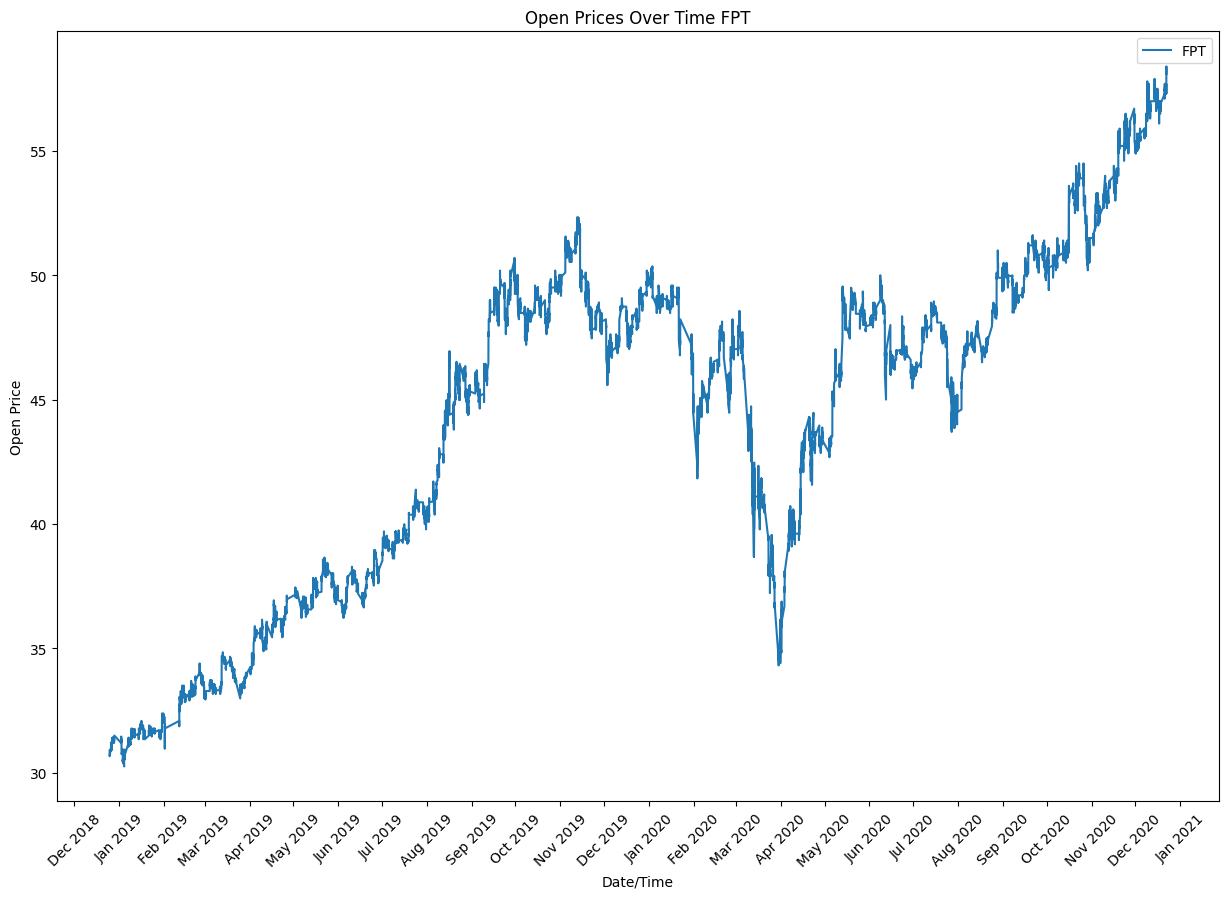

In [12]:

plt.figure(figsize=(15, 10))
plt.plot(FPT_df['Date/Time'], FPT_df['Open'], label='FPT')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel('Date/Time')
plt.ylabel('Open Price')
plt.title('Open Prices Over Time FPT')
plt.legend()

plt.show()


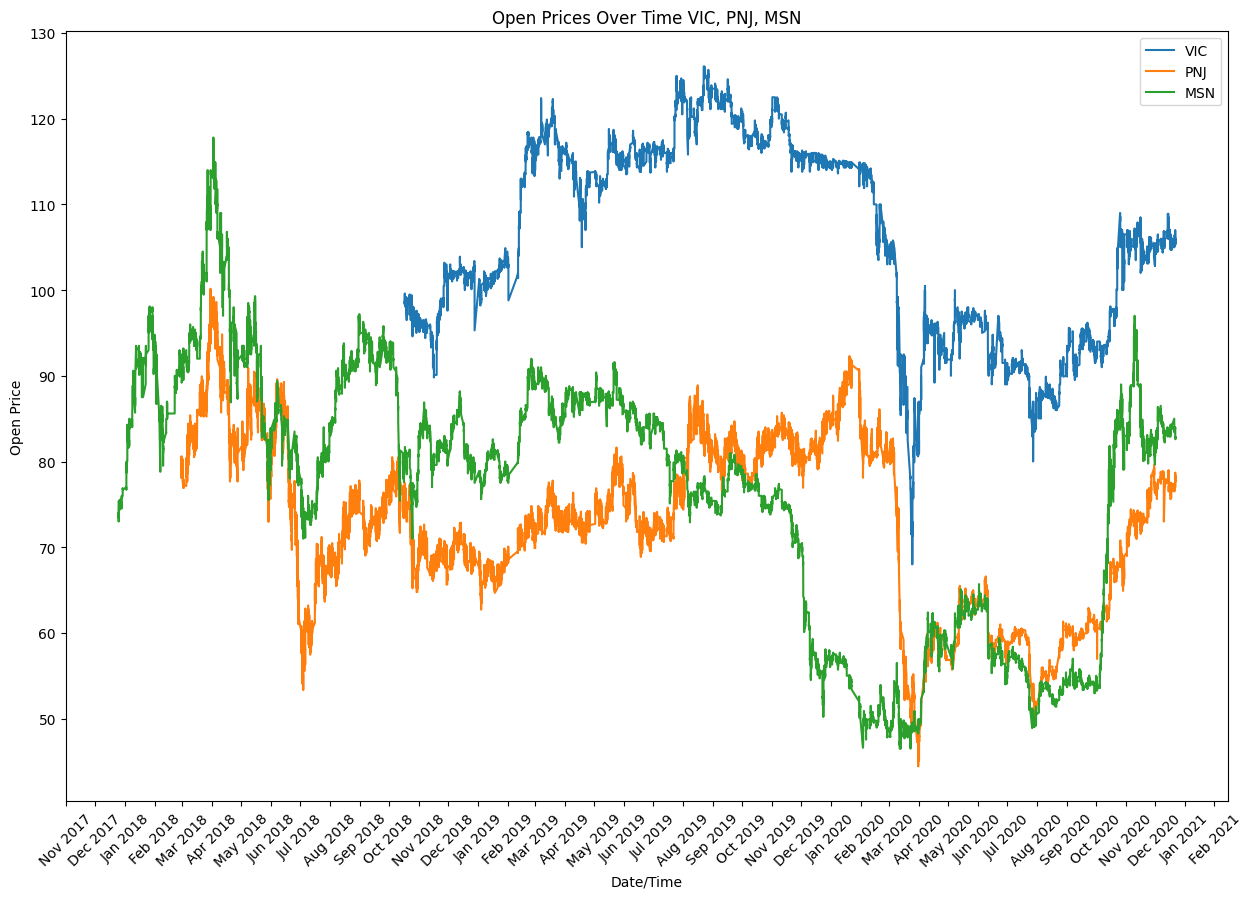

In [13]:

plt.figure(figsize=(15, 10))

for df, label in zip([VIC_df, PNJ_df, MSN_df], ['VIC', 'PNJ', 'MSN']):
    plt.plot(df['Date/Time'], df['Open'], label=label)

# Formatting x-axis as months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set interval to 1 for every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel('Date/Time')
plt.ylabel('Open Price')
plt.title('Open Prices Over Time VIC, PNJ, MSN')
plt.legend()


plt.show()

## 4.2. **Close Price Over Time**

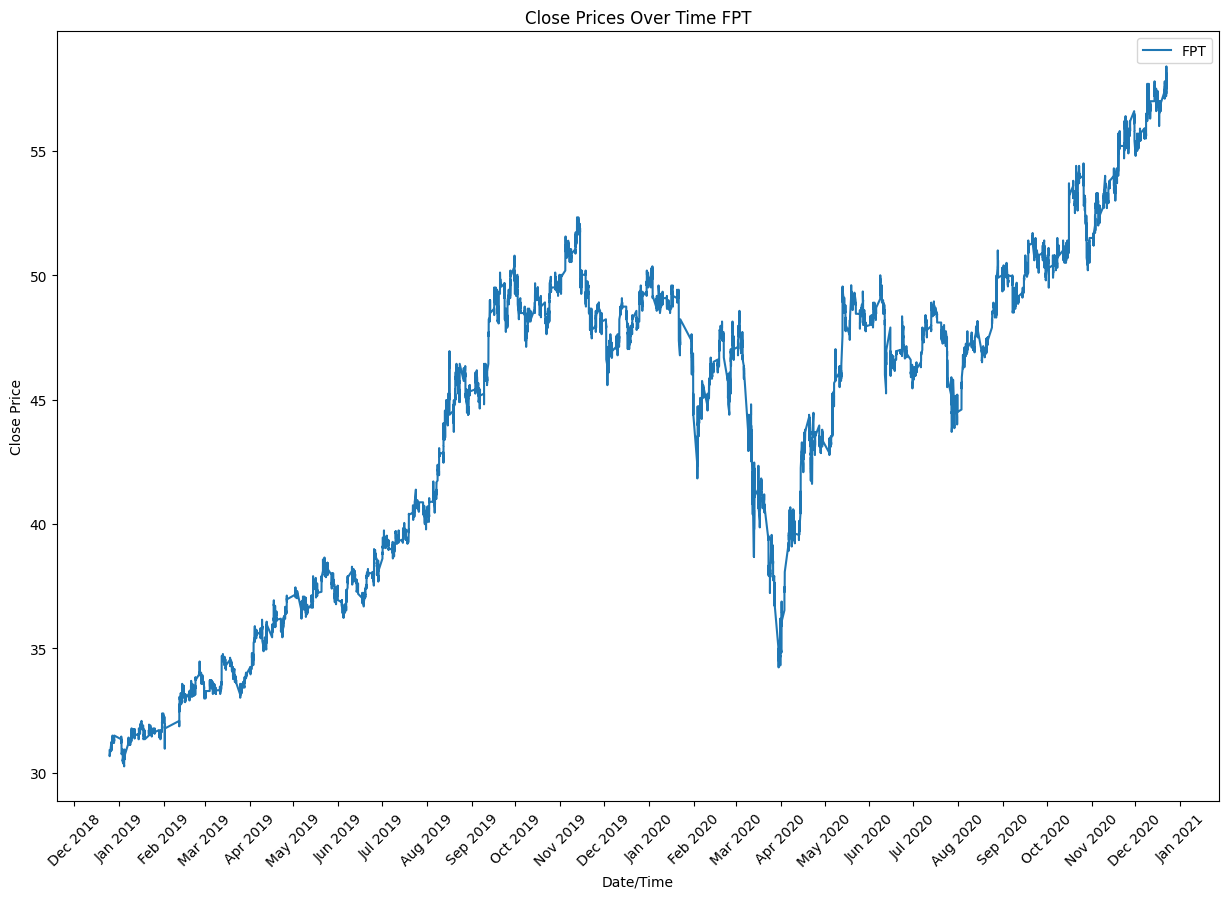

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(FPT_df['Date/Time'], FPT_df['Close'], label='FPT')


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel('Date/Time')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time FPT')
plt.legend()

plt.show()

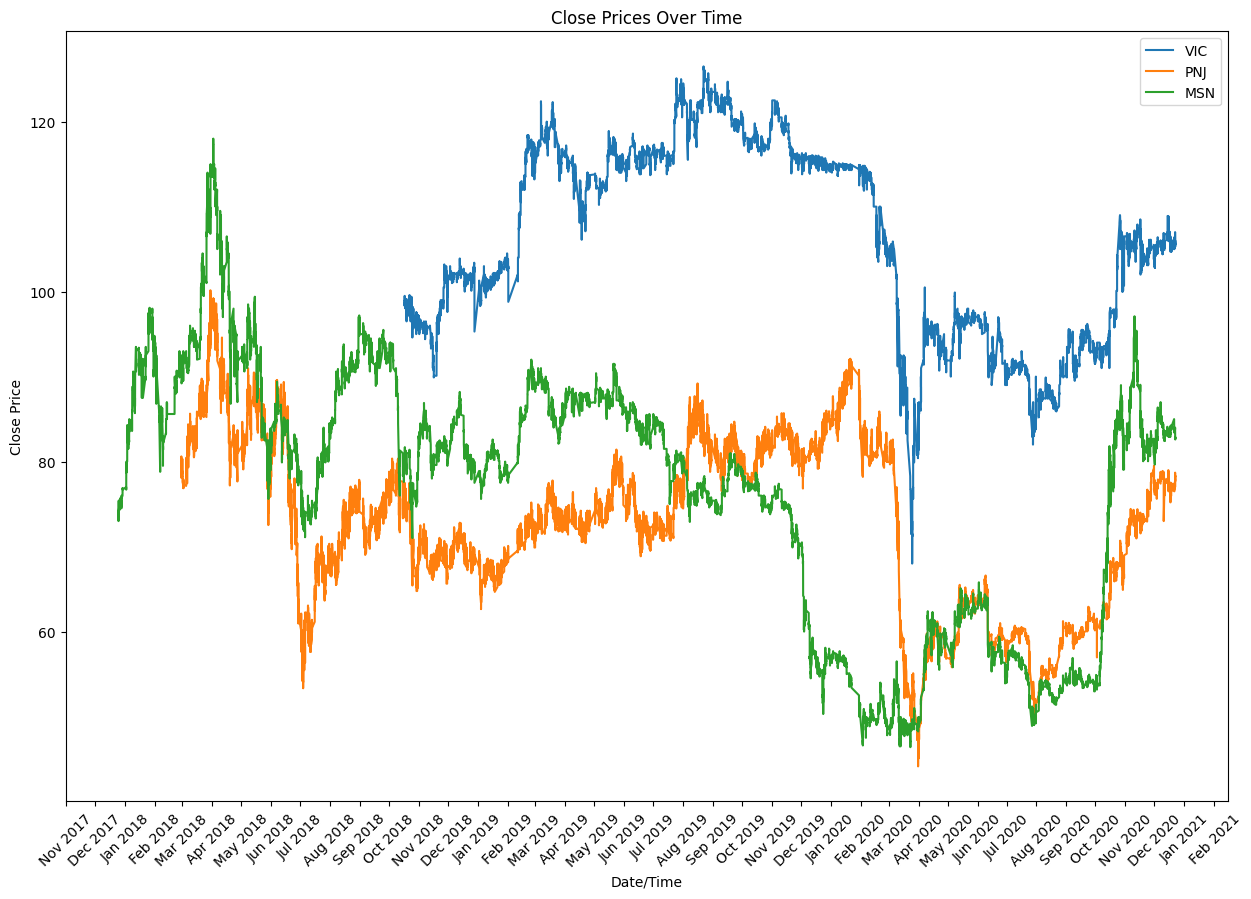

In [15]:
plt.figure(figsize=(15, 10))

for df, label in zip([VIC_df, PNJ_df, MSN_df], ['VIC', 'PNJ', 'MSN']):
    plt.plot(df['Date/Time'], df['Close'], label=label)


plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.xlabel('Date/Time')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.legend()


plt.show()

## 4.3. **Total Traded, Returns**

In [16]:
FPT_df['total traded'] = FPT_df['Open'] * FPT_df['Volume']
VIC_df['total traded'] = VIC_df['Open'] * VIC_df['Volume']
PNJ_df['total traded'] = PNJ_df['Open'] * PNJ_df['Volume']
MSN_df['total traded'] = MSN_df['Open'] * MSN_df['Volume']

FPT_df['returns'] = FPT_df['Close'].pct_change(1)
VIC_df['returns'] = VIC_df['Close'].pct_change(1)
PNJ_df['returns'] = PNJ_df['Close'].pct_change(1)
MSN_df['returns'] = MSN_df['Close'].pct_change(1)

In [17]:
print(FPT_df.info())
print(VIC_df.info())
print(PNJ_df.info())
print(MSN_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Ticker         97406 non-null  object        
 1   Date/Time      97406 non-null  datetime64[ns]
 2   Open           97406 non-null  float64       
 3   High           97406 non-null  float64       
 4   Low            97406 non-null  float64       
 5   Close          97406 non-null  float64       
 6   Volume         97406 non-null  int64         
 7   Open Interest  97406 non-null  int64         
 8   total traded   97406 non-null  float64       
 9   returns        97405 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 7.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         ----------

# 5.  **Preproccsing**

In [18]:
# 'Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest', 'total traded', 'returns' 
features = ['Open', 'High', 'Low', 'Volume', 'Open Interest', 'total traded', 'returns']
target = ['Close']

In [19]:
# Điền NaN bằng -999
FPT_df['returns'].fillna(-999, inplace=True)
VIC_df['returns'].fillna(-999, inplace=True)
PNJ_df['returns'].fillna(-999, inplace=True)
MSN_df['returns'].fillna(-999, inplace=True)

In [20]:
# Phương thức xử lý bộ Data frame 
def preproccsingDF(DF):
    # Sắp xếp dữ liệu theo thời gian
    DF = DF.sort_values(by='Date/Time')

    X = DF[features].values
    y = DF[target].values
    dates=  DF['Date/Time'].values
    return X,y,dates


# Phương thức tạo bộ X, y và dates theo sequence 
def create_sequences(X, y,dates, sequence_length):
    X_seq, y_seq, dates_seq = [], [],[]
    for i in range(len(X) - sequence_length):
        seq_x = X[i:i + sequence_length, :]
        seq_y = y[i + sequence_length] # chỉ quan tâm đến giá Close
        seq_d =dates[i + sequence_length] 
        X_seq.append(seq_x)
        y_seq.append(seq_y)
        dates_seq.append(seq_d)
    return np.array(X_seq), np.array(y_seq), np.array(dates_seq)


# Khởi tạo scaler
def scalerXy(X,y, scaler):
    # Fit và transform scaler cho features và target
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y)
    return X_scaled, y_scaled,scaler


class TrainingDataSplitter:
    def __init__(self, DF, scaler, test_ratio=0.15, val_ratio=0.15):
        self.X, self.y, self.dates = preproccsingDF(DF)
        self.X_scaled, self.y_scaled, self.scaler = scalerXy(self.X, self.y, scaler)

        # Chia thành tập huấn luyện, tập validation và tập kiểm thử
        training_ratio = 1 - (test_ratio + val_ratio)

        split_point_train = int(training_ratio * len(self.X))
        split_point_val = int(val_ratio * len(self.X))

        self.X_train = self.X_scaled[:split_point_train]
        self.y_train = self.y_scaled[:split_point_train]
        self.dates_train = self.dates[:split_point_train]

        self.X_val = self.X_scaled[split_point_train:split_point_train + split_point_val]
        self.y_val = self.y_scaled[split_point_train:split_point_train + split_point_val]
        self.dates_val = self.dates[split_point_train:split_point_train + split_point_val]

        self.X_test = self.X_scaled[split_point_train + split_point_val:]
        self.y_test = self.y_scaled[split_point_train + split_point_val:]
        self.dates_test = self.dates[split_point_train + split_point_val:]

        sequence_length = 50

        # Sử dụng cả X và y khi tạo dãy thời gian
        self.X_train_seq, self.y_train_seq, self.dates_train_seq = create_sequences(
            self.X_train, self.y_train, self.dates_train, sequence_length
        )
        self.X_val_seq, self.y_val_seq, self.dates_val_seq = create_sequences(
            self.X_val, self.y_val, self.dates_val, sequence_length
        )
        self.X_test_seq, self.y_test_seq, self.dates_test_seq = create_sequences(
            self.X_test, self.y_test, self.dates_test, sequence_length
        )

    def get_scaler(self):
        return self.scaler

    def get_data(self):
        return (
            self.X_train_seq,
            self.y_train_seq,
            self.dates_train_seq,
            self.X_val_seq,
            self.y_val_seq,
            self.dates_val_seq,
            self.X_test_seq,
            self.y_test_seq,
            self.dates_test_seq,
        )

In [21]:
# Hàm tính RMSE
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Hàm tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


# 6. **LSTM model**

In [22]:

class LSTMPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(LSTMPredictionModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        out = self.fc(out[:, -1, :])
        return out
def create_model(X_train_seq,layer_units):  
    # Khởi tạo mô hình
    model_lstm = LSTMPredictionModel(input_size=X_train_seq.shape[2], hidden_size=layer_units, output_size=1)

    # Hiển thị cấu trúc mô hình
    print(model_lstm)
    return model_lstm

In [23]:
def train_val_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq ,batch_size ,lr , epochs, layer_units):
    model_lstm= create_model(X_train_seq,layer_units)
    # Chuyển đổi dữ liệu sang định dạng PyTorch
    X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
    X_val_tensor= torch.tensor(X_val_seq, dtype=torch.float32)
    y_val_tensor= torch.tensor(y_val_seq, dtype=torch.float32)

    # Create DataLoader for batching
    train_data = torch.utils.data.TensorDataset(X_train_seq_tensor, y_train_seq_tensor)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # Định nghĩa hàm loss và optimizer
    criterion_lstm = nn.MSELoss()
    optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=lr)

    # Learning rate scheduler with patience
    scheduler = ReduceLROnPlateau(optimizer_lstm, mode='min', patience=5, verbose=True)

    # Huấn luyện mô hình
    best_loss = float('inf')
    patience = 10
    model_lstm.train()
    print("Training Proccessing...")

    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            outputs_lstm = model_lstm(batch_X)
            loss_lstm = criterion_lstm(outputs_lstm, batch_y)

            optimizer_lstm.zero_grad()
            loss_lstm.backward()
            optimizer_lstm.step()

        # Validate the model
        with torch.no_grad():
            model_lstm.eval()
            val_loss = 0.0
            for val_batch_X, val_batch_y in val_loader:
                val_outputs = model_lstm(val_batch_X)
                val_loss += criterion_lstm(val_outputs, val_batch_y).item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_lstm.item()}, Validation Loss: {val_loss}")

        # Update learning rate scheduler and check for early stopping
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping. No improvement for {} epochs.".format(patience))
                break
    return model_lstm

In [24]:
# Dự đoán biến động giá cho bộ dữ liệu test
def predict(model_lstm, X_train_seq, X_val_seq ,X_test_seq):
    X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
    model_lstm.eval()
    with torch.no_grad():
        y_pred_test  = model_lstm(X_test_seq_tensor)
        y_pred_train  = model_lstm(X_train_seq_tensor)
        y_pred_val  = model_lstm(X_val_tensor)
        
    print(y_pred_test.shape , y_pred_train.shape ,y_pred_val.shape )
    
    y_pred_test_last = y_pred_test[:, 0]
    y_pred_train_last = y_pred_train[:, 0]
    y_pred_val_last = y_pred_val[:, 0]
    
    # Chuyển kết quả về numpy array
    y_pred_test_last = y_pred_test_last.cpu().numpy()
    y_pred_train_last = y_pred_train_last.cpu().numpy()
    y_pred_val_last = y_pred_val_last.cpu().numpy()
    return y_pred_train_last, y_pred_val_last, y_pred_test_last


In [25]:
def calculation_RMSE_MAPE(y_pred,y_actual, scaler):
    # Đổi giá trị dự đoán từ dạng normalized về giá thực tế sử dụng scaler.inverse_transform
    y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_actual.reshape(-1, 1))

    # Dùng hàm để tính RMSE và MAPE
    RMSE = calculate_rmse(y_test_actual, y_pred_actual)
    MAPE = calculate_mape(y_test_actual, y_pred_actual)

    print("RMSE:", RMSE)
    print("MAPE:", MAPE)
    return RMSE, MAPE

In [26]:
def plot_stock_trend(y_pred ,y_actual,dates, name , scaler):
    y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_actual = scaler.inverse_transform(y_actual.reshape(-1, 1))

    # Vẽ biểu đồ cho Bộ Val trên giá Close (Đóng cửa) với giá thực tế và giá dự đoán
    plt.figure(figsize=(10, 5))
    plt.plot(dates, y_actual, label=f"Giá thực tế ( {name} )")
    plt.plot(dates, y_pred_actual, label=f"Giá dự đoán ( {name} )")
    plt.title(f"So sánh giá Close dự đoán và giá thực tế trên bộ {name}")
    plt.xlabel('Chỉ số thời gian')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()
def synthetic_plot_stock_trend(y_train ,y_test, y_val, y_test_pred, y_val_pred, dates_train, dates_val, dates_test, scaler):
    # Vẽ biểu đồ tổng hợp cho 3 bộ Train, Val, Test trên giá Close (Đóng cửa) với giá thực tế và giá dự đoán
    y_test_pred_actual = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    y_val_pred_actual = scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
    
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))

    plt.figure(figsize=(15, 8))
    plt.plot(dates_test, y_test_actual, label='Giá thực tế (Test)')
    plt.plot(dates_test, y_test_pred_actual, label='Giá dự đoán (Test)')
    plt.plot(dates_val, y_val_actual, label='Giá thực tế (Val)')
    plt.plot(dates_val, y_val_pred_actual, label='Giá dự đoán (Val)')
    plt.plot(dates_train, y_train_actual, label='Giá thực tế (Train)')
    plt.title('So sánh giá Close dự đoán và giá thực tế trên bộ train và test')
    plt.xlabel('Chỉ số thời gian')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()

In [27]:
# Bắt đầu với bộ dữ liệu FPT_df
layer_units = 50
epochs = 15
batch_size  =8
lr = 0.001
scaler = MinMaxScaler()
# Phân chia dữ liệu theo bộ Train , Test, Val (X, y, dates) và Scaler đã fit với bộ dữ liệu đó
#Thay bộ dữ liệu tương ứng FPT_df, VIC_df, PNJ_df, MSN_df
data_splitter = TrainingDataSplitter(FPT_df, scaler)
scaler = data_splitter.get_scaler()
X_train_seq, y_train_seq, dates_train_seq, X_val_seq, y_val_seq, dates_val_seq, X_test_seq, y_test_seq, dates_test_seq = data_splitter.get_data()

In [28]:
model_lstm = train_val_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq ,batch_size ,lr , epochs, layer_units)

LSTMPredictionModel(
  (lstm1): LSTM(7, 50, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(50, 50, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
Training Proccessing...
Epoch [1/15], Training Loss: 0.00021143333287909627, Validation Loss: 0.00022846577887626303
Epoch [2/15], Training Loss: 2.187283143939567e-06, Validation Loss: 5.96572122675325e-06
Epoch [3/15], Training Loss: 8.311980309372302e-06, Validation Loss: 6.237873979061063e-06
Epoch [4/15], Training Loss: 2.556015942900558e-06, Validation Loss: 8.01389861082653e-06
Epoch [5/15], Training Loss: 1.5776664440636523e-05, Validation Loss: 7.308872742342018e-06
Epoch [6/15], Training Loss: 5.795356628368609e-06, Validation Loss: 5.522403871840662e-06
Epoch [7/15], Training Loss: 1.6230704886766034e-06, Validation Loss: 4.081536949570988e-06
Epoch [8/15], Training Loss: 6.878849944769172e-06, Validation Loss: 7.7728807278183e

In [29]:
y_pred_train_last, y_pred_val_last, y_pred_test_last = predict(model_lstm, X_train_seq, X_val_seq ,X_test_seq)

torch.Size([14562, 1]) torch.Size([68134, 1]) torch.Size([14560, 1])


In [30]:
RMSE, MAPE = calculation_RMSE_MAPE(y_pred_test_last,y_test_seq , scaler)

RMSE: 0.08606405663960222
MAPE: 0.11838062159341527


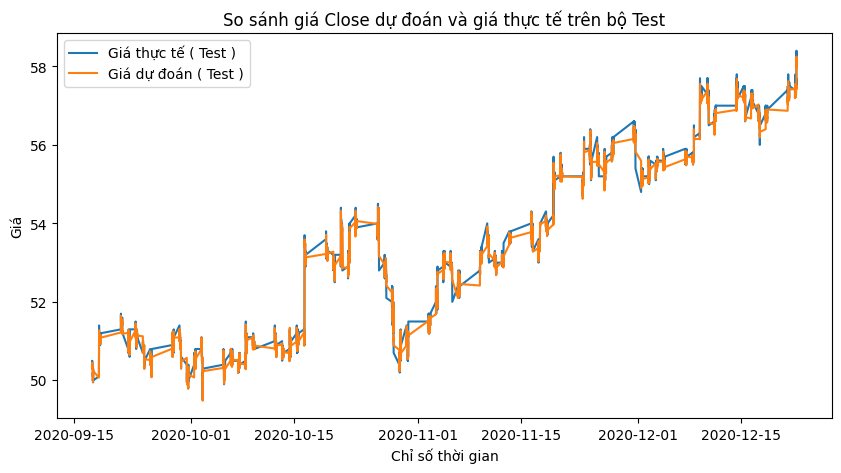

In [31]:
#Test plot stock trend
plot_stock_trend(y_pred_test_last ,y_test_seq,dates_test_seq, name="Test", scaler = scaler )

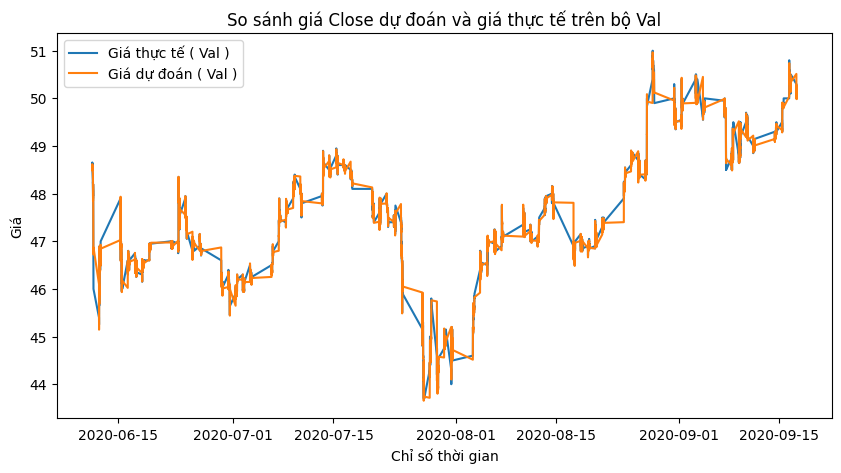

In [32]:
#Val plot stock trend
plot_stock_trend(y_pred_val_last ,y_val_seq,dates_val_seq, name="Val", scaler = scaler )

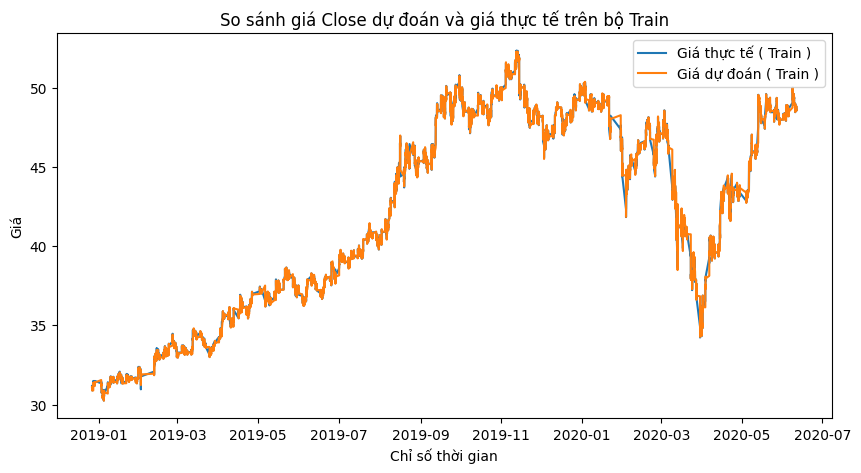

In [33]:
#Train plot stock trend
plot_stock_trend(y_pred_train_last ,y_train_seq,dates_train_seq, name="Train", scaler = scaler )

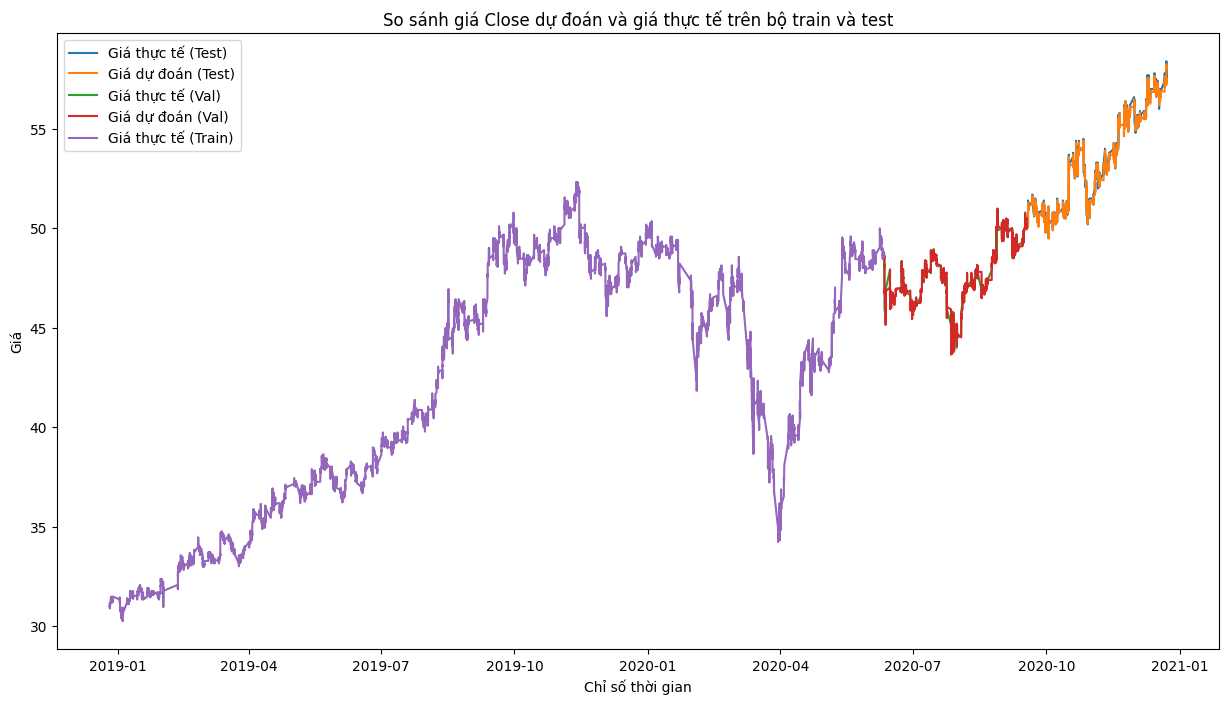

In [34]:
#Vẽ sơ đồ tổng hợp 

synthetic_plot_stock_trend(y_train_seq ,y_test_seq, y_val_seq, y_pred_test_last, y_pred_val_last, dates_train_seq, dates_val_seq, dates_test_seq, scaler = scaler)